In [3]:
!pip install kaggle
!mkdir ~/.kaggle
from google.colab import files
files.upload()  # Upload kaggle.json then continue
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d fedesoriano/heart-failure-prediction -p data --unzip


mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0
  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 23.9MB/s]


In [4]:
import pandas as pd
df = pd.read_csv("data/heart.csv")
df.head()
df.shape


(918, 12)

In [5]:
df["HeartDisease"].value_counts(normalize=True)


,proportion
HeartDisease,
1,0.553377
0,0.446623


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load data
df = pd.read_csv("data/heart.csv")

# Display basic info
df.head(), df.shape


(   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
 0   40   M           ATA        140          289          0     Normal    172   
 1   49   F           NAP        160          180          0     Normal    156   
 2   37   M           ATA        130          283          0         ST     98   
 3   48   F           ASY        138          214          0     Normal    108   
 4   54   M           NAP        150          195          0     Normal    122   
 
   ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
 0              N      0.0       Up             0  
 1              N      1.0     Flat             1  
 2              N      0.0       Up             0  
 3              Y      1.5     Flat             1  
 4              N      0.0       Up             0  ,
 (918, 12))

In [7]:
# Define features and target
target = "HeartDisease"
X = df.drop(columns=[target])
y = df[target]


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

X_train.shape, X_valid.shape, X_test.shape


((550, 11), (184, 11), (184, 11))

In [9]:
y_train.value_counts(normalize=True), y_valid.value_counts(normalize=True), y_test.value_counts(normalize=True)


(HeartDisease
 1    0.552727
 0    0.447273
 Name: proportion, dtype: float64,
 HeartDisease
 1    0.554348
 0    0.445652
 Name: proportion, dtype: float64,
 HeartDisease
 1    0.554348
 0    0.445652
 Name: proportion, dtype: float64)

### SEMMA Stage 1 — SAMPLE

In this phase, we imported the real-world Heart Disease dataset from Kaggle.  
We defined our target variable (`HeartDisease`) and split the data into training, validation, and testing subsets using a 60/20/20 ratio.

- Training set: used to build the model
- Validation set: used to tune and select the model
- Test set: used for final evaluation

The dataset is balanced across both classes, making it suitable for classification without needing oversampling techniques.


In [10]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


,0
Age,0
Sex,0
ChestPainType,0
RestingBP,0
Cholesterol,0
FastingBS,0
RestingECG,0
MaxHR,0
ExerciseAngina,0
Oldpeak,0


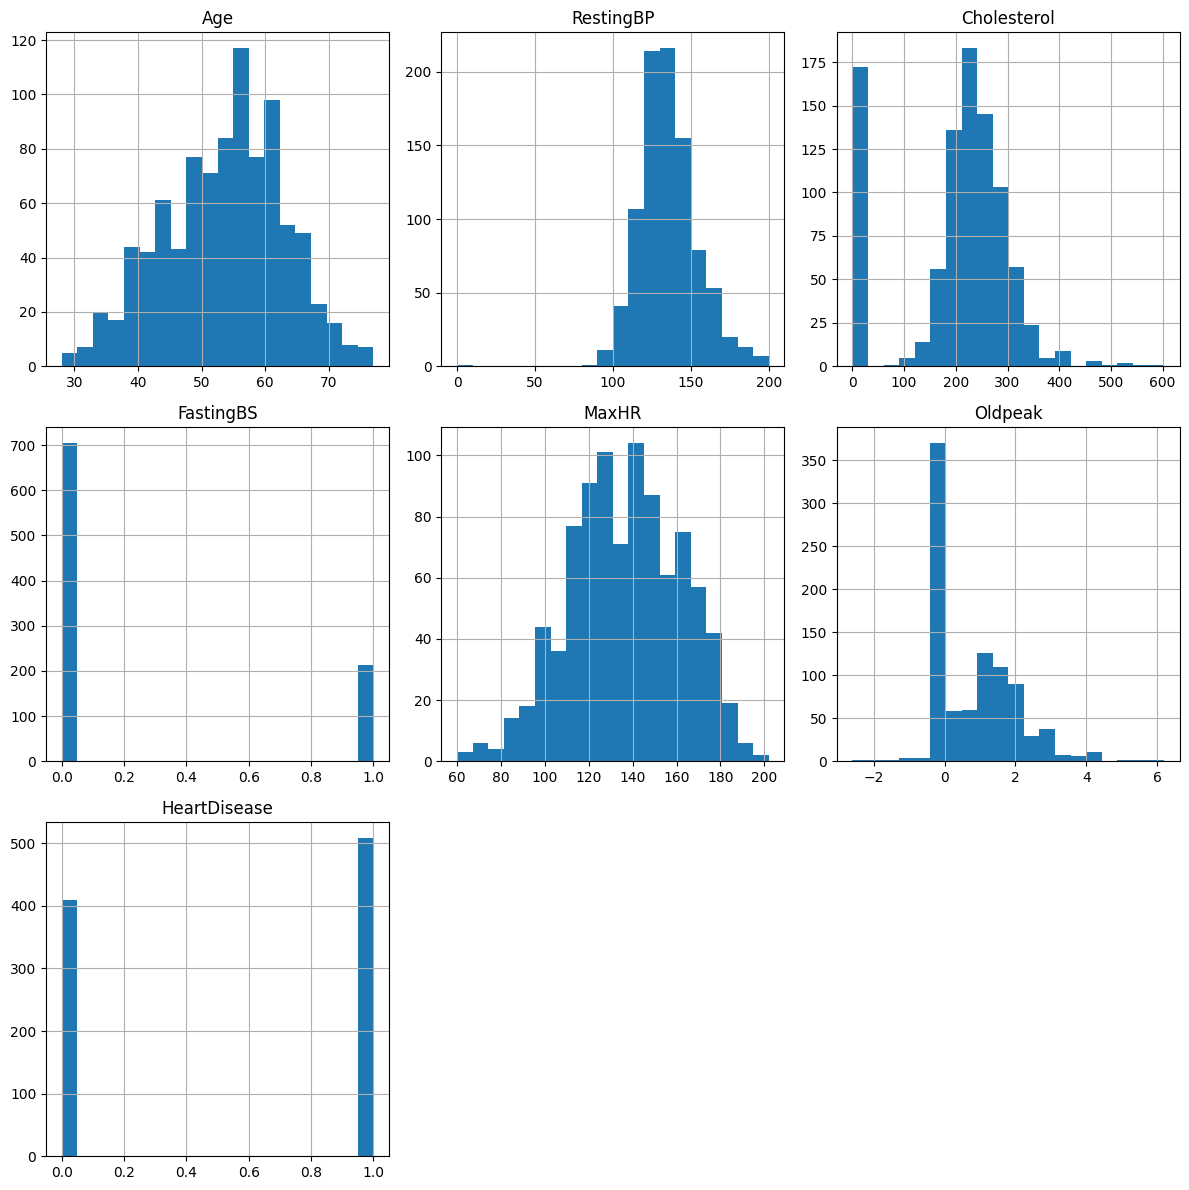

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df.hist(figsize=(12,12), bins=20)
plt.tight_layout()
plt.show()


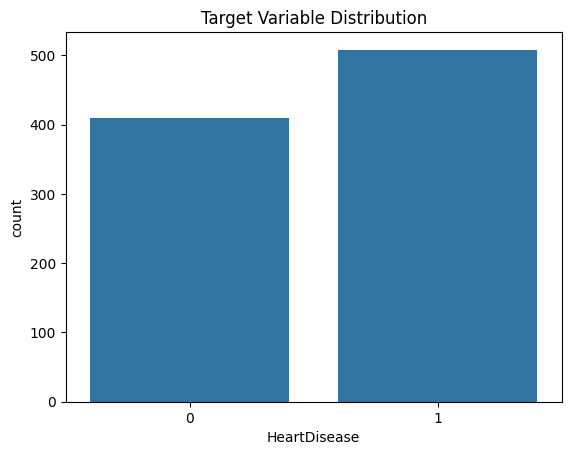

In [12]:
sns.countplot(data=df, x="HeartDisease")
plt.title("Target Variable Distribution")
plt.show()


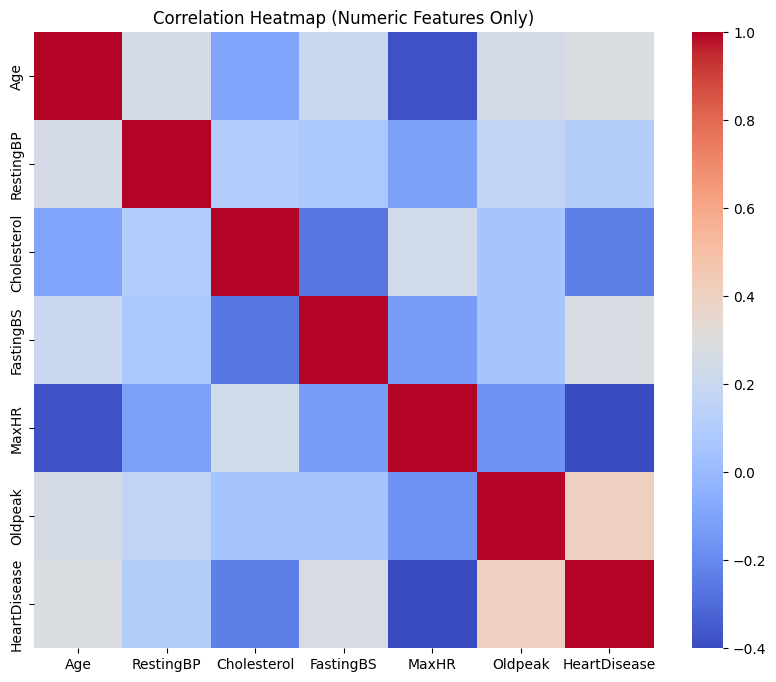

In [14]:
plt.figure(figsize=(10,8))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap (Numeric Features Only)")
plt.show()


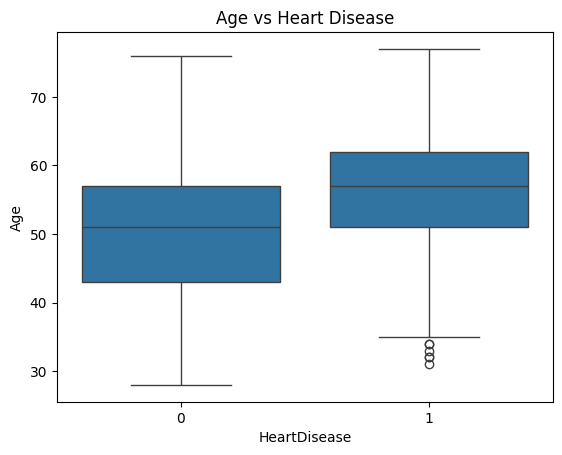

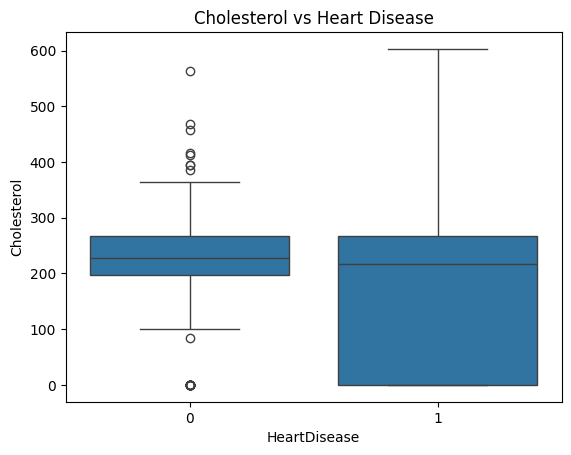

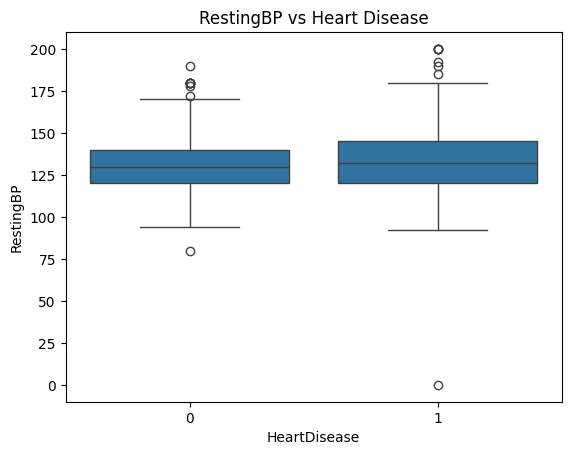

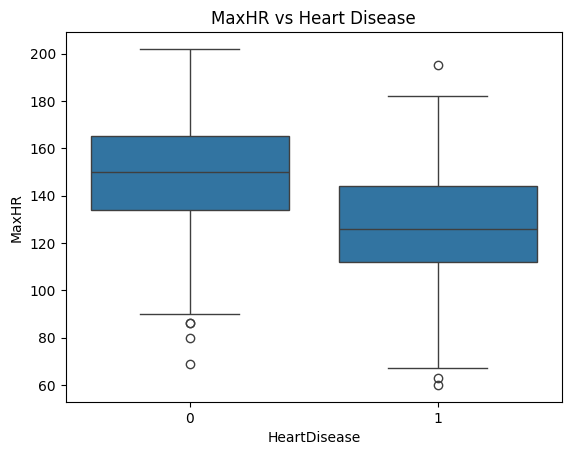

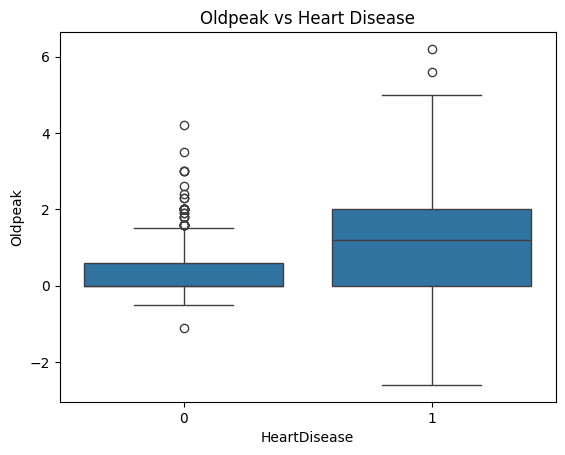

In [15]:
features = ["Age","Cholesterol","RestingBP","MaxHR","Oldpeak"]

for col in features:
    plt.figure()
    sns.boxplot(x="HeartDisease", y=col, data=df)
    plt.title(f"{col} vs Heart Disease")
    plt.show()


In [16]:
X = df.drop(columns=["HeartDisease"])
y = df["HeartDisease"]


In [17]:
numeric_cols = X.select_dtypes(include=["int64","float64"]).columns
categorical_cols = X.select_dtypes(include=["object"]).columns

numeric_cols, categorical_cols


(Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object'),
 Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object'))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)


In [20]:
preprocess.fit(X_train)


ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak'], dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'], dtype='object'))])

In [21]:
X_train_processed = preprocess.transform(X_train)
X_valid_processed = preprocess.transform(X_valid)
X_test_processed  = preprocess.transform(X_test)


In [22]:
import joblib

joblib.dump(preprocess, "preprocessor.pkl")


['preprocessor.pkl']

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_processed, y_train)

y_pred_lr = log_reg.predict(X_valid_processed)
print("Logistic Regression Accuracy:", accuracy_score(y_valid, y_pred_lr))
print(classification_report(y_valid, y_pred_lr))


Logistic Regression Accuracy: 0.9130434782608695
              precision    recall  f1-score   support

           0       0.96      0.84      0.89        61
           1       0.88      0.97      0.93        77

    accuracy                           0.91       138
   macro avg       0.92      0.91      0.91       138
weighted avg       0.92      0.91      0.91       138



In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_processed, y_train)

y_pred_rf = rf.predict(X_valid_processed)
print("Random Forest Accuracy:", accuracy_score(y_valid, y_pred_rf))
print(classification_report(y_valid, y_pred_rf))


Random Forest Accuracy: 0.8913043478260869
              precision    recall  f1-score   support

           0       0.94      0.80      0.87        61
           1       0.86      0.96      0.91        77

    accuracy                           0.89       138
   macro avg       0.90      0.88      0.89       138
weighted avg       0.90      0.89      0.89       138



In [25]:
!pip install xgboost --quiet


In [26]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_model.fit(X_train_processed, y_train)

y_pred_xgb = xgb_model.predict(X_valid_processed)
print("XGBoost Accuracy:", accuracy_score(y_valid, y_pred_xgb))
print(classification_report(y_valid, y_pred_xgb))


XGBoost Accuracy: 0.8840579710144928
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        61
           1       0.89      0.91      0.90        77

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138



In [27]:
print("LR:", accuracy_score(y_valid, y_pred_lr))
print("RF:", accuracy_score(y_valid, y_pred_rf))
print("XGB:", accuracy_score(y_valid, y_pred_xgb))


LR: 0.9130434782608695
RF: 0.8913043478260869
XGB: 0.8840579710144928


In [28]:
from sklearn.pipeline import Pipeline
import joblib

final_model = Pipeline([
    ("preprocessor", preprocess),
    ("model", xgb_model)
])

joblib.dump(final_model, "heart_disease_model.pkl")
print("✅ Model saved as heart_disease_model.pkl")


✅ Model saved as heart_disease_model.pkl


In [29]:
import joblib
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

final_model = joblib.load("heart_disease_model.pkl")

y_pred_test = final_model.predict(X_test)

print("✅ Test Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))


✅ Test Accuracy: 0.8913043478260869
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        62
           1       0.93      0.87      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138



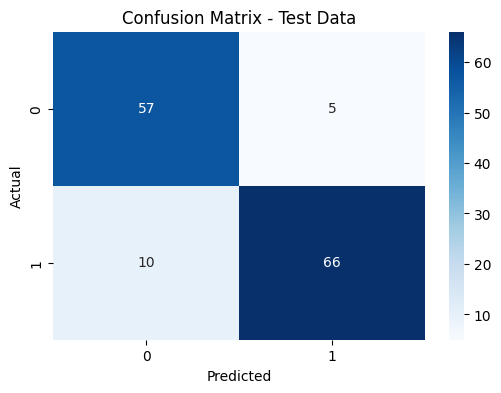

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


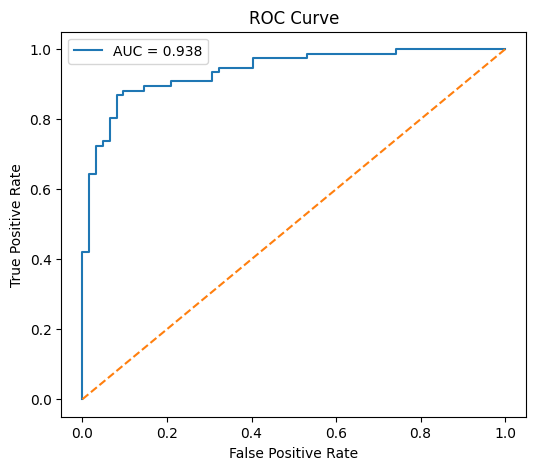

In [31]:
from sklearn.metrics import roc_curve, auc

y_prob = final_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [32]:
!pip install shap --quiet


In [34]:
preprocessor = final_model.named_steps["preprocessor"]
xgb_model = final_model.named_steps["model"]  # XGBClassifier


In [35]:
X_test_enc = preprocessor.transform(X_test)

# Convert to array if sparse
if hasattr(X_test_enc, "toarray"):
    X_test_enc = X_test_enc.toarray()


PermutationExplainer explainer: 139it [01:15,  1.82it/s]


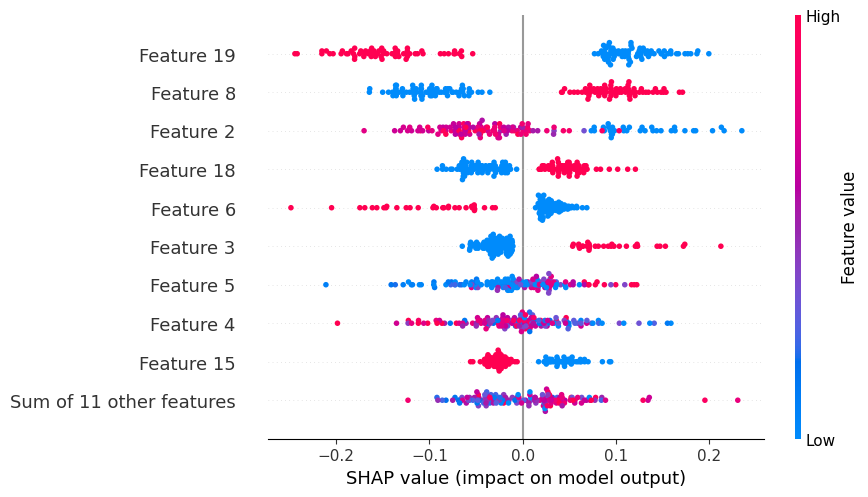

In [37]:
import shap

# Encode test data
X_test_enc = preprocessor.transform(X_test)
if hasattr(X_test_enc, "toarray"):
    X_test_enc = X_test_enc.toarray()

# Use SHAP model-agnostic explainer
explainer = shap.Explainer(xgb_model.predict_proba, X_test_enc)
shap_values = explainer(X_test_enc)

# Beeswarm plot
shap.plots.beeswarm(shap_values[:,:,1])


/tmp/ipython-input-413273216.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values[:,:,1].values, X_test_enc)


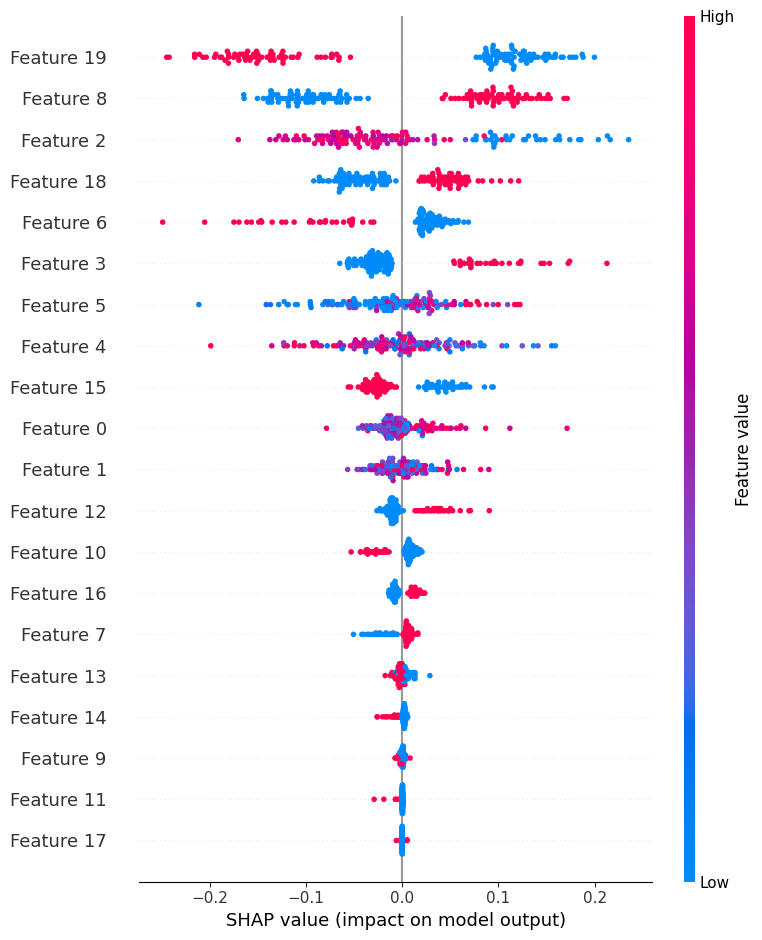

In [38]:
shap.summary_plot(shap_values[:,:,1].values, X_test_enc)


In [39]:
import joblib

joblib.dump(final_model, "heart_disease_final_pipeline.pkl")
print("✅ Model saved!")


✅ Model saved!


In [40]:
import pandas as pd

sample = {
    "Age": 54,
    "Sex": "M",
    "ChestPainType": "ATA",
    "RestingBP": 140,
    "Cholesterol": 239,
    "FastingBS": 0,
    "RestingECG": "Normal",
    "MaxHR": 160,
    "ExerciseAngina": "N",
    "Oldpeak": 1.2,
    "ST_Slope": "Flat"
}

sample_df = pd.DataFrame([sample])
prediction = final_model.predict(sample_df)[0]
probability = final_model.predict_proba(sample_df)[0][1]

print("Predicted Heart Disease:", "YES" if prediction==1 else "NO")
print("Probability:", round(probability,4))


Predicted Heart Disease: NO
Probability: 0.2079


In [42]:
def predict_heart_disease(model, data: dict):
    df = pd.DataFrame([data])
    pred = model.predict(df)[0]
    prob = model.predict_proba(df)[0][1]
    return {
        "prediction": "Heart Disease" if pred==1 else "Healthy",
        "probability": round(prob,4)
    }

predict_heart_disease(final_model, sample)


{'prediction': 'Healthy', 'probability': np.float32(0.2079)}

In [43]:
!pip freeze > requirements.txt
